In [36]:
# An improved version of MNielsen_network, implementing the SGD learning algorithm for a feedforward neural network.
# Improvments include 
# 1. the cross-entropy cost function, 
# 2. regularization, 
# 3. better initialization of the weights.

import json
import random
import sys
import numpy as np

# define the quadratic and cross-entropy cost functions

class QuadraticCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2
    
    # return the error delta from the output layer.
    @staticmethod
    def delta(z, a, y):
        return (a-y)*sigmoid_prime(z)
    
class CrossEntropyCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    # np.nan_to_num is used to ensure numerical stability, make sure 0*log(0) = 0.0
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    # returm the error delta from the output layer.
    # parameter "z" is not used by the method. 
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
# Main Network class
class Network2(object):
    
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        
        # the biases and weights for the network are initiated randomly, using "self.default_weight_initializer".
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
    
    def default_weight_initializer(self):
        
        # initialize each weight using a Gaussian distribution with mean 0 and standard deviation 1
        # over the square root of the number of weights connecting to the same neuron. 
        # initialize the biases using a Gaussian distribution with mean 0 and standard deviation 1.
    
        # for the input layers, there is no biases.
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
            
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    # "evaluation_data", monitor the cost and accuracy on either the evaluation data or the training data.
    # returns a tuple containing four lists:
    # 1. the (per-epoch) costs on the evaluation data,
    # 2. the accuracies on the evaluation data,
    # 3. the costs on the training data,
    # 4. the accuracies on the training data.
    # If we train for 30 epochs, then the first element of the tuple will be a 
    # 30-element list containing the cost on the evaluation data at the end of each epoch.
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0,
            evaluation_data = None,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            monitor_training_cost = False,
            monitor_training_accuracy = False,
            early_stopping_n = 0):
        
        # early stopping functionality:
        best_accuracy=1
        
        training_data = list(training_data)
        n = len(training_data)
        
        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)
            
        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0
        
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
                
            print("Epoch %s training complete" % j)
            
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
            
            print()
            
            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    print("Early-stopping: Best so far{}".format(best_accuracy))
                else:
                    no_accuracy_change += 1
                    
                if (no_accuracy_change == early_stopping_n):
                    print("Early-stopping: No accuracy cahnge in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
        
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
    
    
    # "mini_batch" is a list of tuples "(x,y)"
    # "eta" is the learning rate
    # "lmbda" is the regularization parameter
    # "n" is the total size of the training set.
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # "eta*(lmbda/n)*w" comes from the regularization term.
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backpropagate
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    
    def accuracy(self, data, convert=False):
     
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        
        result_accuracy = sum(int(x==y) for (x,y) in results)
        return result_accuracy
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    # Save the neural network to the file "filename".
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        
        
# Loading a Network
def load(filename):
    
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

# Miscellaneous functions
def vectorized_result(j):
    
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))
        
        
                
        
        

In [37]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[1].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)



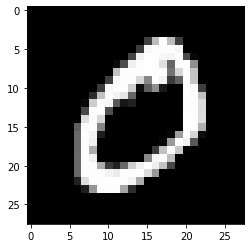

In [38]:
training_data, validation_data, test_data = load_data_wrapper()

In [39]:
net = Network2([784, 30, 10], cost=CrossEntropyCost)

In [40]:
net.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 3827.662107245836
Accuracy on training data: 46922 / 50000
Cost on evaluation data: 3827.654972744784
Accuracy on evaluation data: 9384 / 10000

Epoch 1 training complete
Cost on training data: 4967.765571867481
Accuracy on training data: 47012 / 50000
Cost on evaluation data: 4967.773805158235
Accuracy on evaluation data: 9415 / 10000

Epoch 2 training complete
Cost on training data: 5538.102407348555
Accuracy on training data: 47682 / 50000
Cost on evaluation data: 5538.124248121075
Accuracy on evaluation data: 9512 / 10000

Epoch 3 training complete
Cost on training data: 5874.125826338354
Accuracy on training data: 47949 / 50000
Cost on evaluation data: 5874.150971685845
Accuracy on evaluation data: 9545 / 10000

Epoch 4 training complete
Cost on training data: 6095.720112365904
Accuracy on training data: 48075 / 50000
Cost on evaluation data: 6095.754712910357
Accuracy on evaluation data: 9561 / 10000

Epoch 5 training complete
Cost

([3827.654972744784,
  4967.773805158235,
  5538.124248121075,
  5874.150971685845,
  6095.754712910357,
  6234.89621872204,
  6299.810125270498,
  6390.796511398984,
  6422.823753918947,
  6474.994405714924,
  6482.808583609542,
  6524.741903662258,
  6549.156790914078,
  6553.453465428393,
  6556.016133262081,
  6626.334824549119,
  6610.570604952888,
  6632.877282226619,
  6635.619627696006,
  6690.540689888126,
  6647.94041969377,
  6660.318779831006,
  6646.624424960405,
  6675.983289225715,
  6662.685875321902,
  6676.788065128633,
  6703.8262773331835,
  6742.363059980183,
  6727.66232128075,
  6719.071572497623],
 [9384,
  9415,
  9512,
  9545,
  9561,
  9539,
  9618,
  9581,
  9578,
  9600,
  9574,
  9571,
  9544,
  9573,
  9631,
  9600,
  9553,
  9592,
  9607,
  9589,
  9598,
  9605,
  9591,
  9599,
  9603,
  9600,
  9606,
  9610,
  9615,
  9562],
 [3827.662107245836,
  4967.765571867481,
  5538.102407348555,
  5874.125826338354,
  6095.720112365904,
  6234.873716017939,
  62

In [34]:
netQuadratic = Network2([784, 30, 10], cost=QuadraticCost)

In [35]:
netQuadratic.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 983.7314812494101
Accuracy on training data: 45761 / 50000
Cost on evaluation data: 983.72344184882
Accuracy on evaluation data: 9243 / 10000

Epoch 1 training complete
Cost on training data: 1187.7994988584387
Accuracy on training data: 46500 / 50000
Cost on evaluation data: 1187.7944466338574
Accuracy on evaluation data: 9359 / 10000

Epoch 2 training complete
Cost on training data: 1291.5260954411178
Accuracy on training data: 46868 / 50000
Cost on evaluation data: 1291.5213435501032
Accuracy on evaluation data: 9431 / 10000

Epoch 3 training complete
Cost on training data: 1349.1887245367486
Accuracy on training data: 47086 / 50000
Cost on evaluation data: 1349.1852261197196
Accuracy on evaluation data: 9451 / 10000

Epoch 4 training complete
Cost on training data: 1390.2472006410928
Accuracy on training data: 47220 / 50000
Cost on evaluation data: 1390.2439292629012
Accuracy on evaluation data: 9488 / 10000

Epoch 5 training complet

([983.72344184882,
  1187.7944466338574,
  1291.5213435501032,
  1349.1852261197196,
  1390.2439292629012,
  1418.5741826405447,
  1436.1148700123758,
  1453.85102897469,
  1462.0323966786798,
  1472.7231097190913,
  1478.7886158996707,
  1483.333912146917,
  1489.9406298913611,
  1492.8207661244787,
  1496.3469731280372,
  1499.9077062639117,
  1504.4255480105908,
  1504.6392863895987,
  1506.4301203489288,
  1508.6366769809558,
  1510.7322497715263,
  1511.629626709609,
  1511.2997809997732,
  1517.4445115552303,
  1516.7013562454042,
  1519.1112917258424,
  1520.821344104862,
  1523.9719431798947,
  1525.542676705834,
  1525.8041770741138],
 [9243,
  9359,
  9431,
  9451,
  9488,
  9504,
  9538,
  9507,
  9536,
  9561,
  9541,
  9554,
  9551,
  9547,
  9569,
  9575,
  9566,
  9583,
  9575,
  9572,
  9592,
  9562,
  9568,
  9571,
  9564,
  9584,
  9586,
  9578,
  9590,
  9576],
 [983.7314812494101,
  1187.7994988584387,
  1291.5260954411178,
  1349.1887245367486,
  1390.2472006410928